In [319]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("darkgrid")

In [320]:
##load data
X = np.load('../../data/processed_data/specgram_db_pad_trunc.npy')
## We need to reshape our data to be the correct dimensions for
## the net
## observations, grid, colorvalues

##so we just need to add the colorvalues, 1 here represents single valued
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
print(X.shape)

df = pd.read_csv("../../data/processed_data/metadata.csv")
category_to_number = {'brushing': 0, 'food': 1, 'isolation': 2}

# Create a new column with numerical values based on the mapping
df['numerical_situation'] = df['situation'].map(category_to_number)

y = df['numerical_situation'].values

(440, 128, 67, 1)


In [321]:
## parameter for our data
num_classes = 3
(height, width, channels) = (128,67,1)

In [322]:
#train,test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                       test_size=.2,
                                                       shuffle=True,
                                                       random_state=100,
                                                       stratify=y)



In [323]:
##CNN model in a function
def create_CNN_model(dropout_rate=0,conv_activation='relu',kernel_size=(3,3),pool_size=(2,2),optimizer='adam',filters=32, num_layers=1,num_dense_layers=1):
    
    model = models.Sequential()
    num_layers = 3
    kernel_size = (6,3)
    for _ in range(num_layers):
        model.add(Conv2D(32*(_+1), kernel_size=kernel_size, activation='relu', input_shape=(height, width, channels)))
        model.add(MaxPooling2D(pool_size=pool_size, strides=2))
        
    model.add(Flatten())
    
    for _ in range(num_dense_layers):
        if dropout_rate != 0:
            model.add(Dropout(rate=dropout_rate))  
        model.add(Dense(units=64, activation=conv_activation))
    
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [324]:
# define function to display the results of the grid search
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))    
    


In [325]:
## param_grid for Cross validation
param_grid = {
    'batch_size': [np.size(y_tt)],
    'epochs': [60],
    'conv_activation': ['relu'],
    'dropout_rate': [0.0,0.15,0.30],
    'num_layers': [2,3],
    'filters': [15,30],
    'optimizer': ['sdg','rmsprop','adam'],
    'kernel_size':[(8,4),(6,3)],
    'pool_size':[(2,2),(4,2),(6,3)],
    'num_dense_layers':[1]
}


##split further to test the result of CV
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train,
                                            test_size=.1,
                                            shuffle=True,
                                            random_state=41,
                                            stratify=y_train)

In [ ]:
from time import time
best_accuracy = 0.0
best_params = {}

# wrap the model
keras_classifier = KerasClassifier(model=create_CNN_model, verbose=0,dropout_rate=0.0,conv_activation='relu',kernel_size=(3,3),pool_size=(2,2),optimizer='adam',filters=32, num_layers=1,num_dense_layers=1)
                           
start = time()                    

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3,verbose=3)
grid_result = grid_search.fit(X_tt, to_categorical(y_tt))

                                                       
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_layers=2, optimizer=sdg, pool_size=(2, 2);, score=0.679 total time=  30.5s
[CV 2/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_layers=2, optimizer=sdg, pool_size=(2, 2);, score=0.695 total time=  29.9s
[CV 3/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_layers=2, optimizer=sdg, pool_size=(2, 2);, score=0.743 total time=  29.9s
[CV 1/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_layers=2, optimizer=sdg, pool_size=(4, 2);, score=0.660 total time=  30.4s
[CV 2/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, k

[CV 1/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_layers=3, optimizer=rmsprop, pool_size=(4, 2);, score=0.679 total time=  29.9s
[CV 2/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_layers=3, optimizer=rmsprop, pool_size=(4, 2);, score=0.724 total time=  30.3s
[CV 3/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_layers=3, optimizer=rmsprop, pool_size=(4, 2);, score=0.762 total time=  31.0s
[CV 1/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_layers=3, optimizer=rmsprop, pool_size=(6, 3);, score=0.660 total time=  35.2s
[CV 2/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(8, 4), num_dense_layers=1, num_laye

[CV 1/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(6, 3), num_dense_layers=1, num_layers=2, optimizer=adam, pool_size=(6, 3);, score=0.660 total time=  34.5s
[CV 2/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(6, 3), num_dense_layers=1, num_layers=2, optimizer=adam, pool_size=(6, 3);, score=0.695 total time=  32.9s
[CV 3/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(6, 3), num_dense_layers=1, num_layers=2, optimizer=adam, pool_size=(6, 3);, score=0.705 total time=  34.2s
[CV 1/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(6, 3), num_dense_layers=1, num_layers=3, optimizer=sdg, pool_size=(2, 2);, score=0.736 total time=  32.1s
[CV 2/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=15, kernel_size=(6, 3), num_dense_layers=1, num_layers=3, optimiz

[CV 1/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=30, kernel_size=(8, 4), num_dense_layers=1, num_layers=2, optimizer=rmsprop, pool_size=(2, 2);, score=0.632 total time=  34.4s
[CV 2/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=30, kernel_size=(8, 4), num_dense_layers=1, num_layers=2, optimizer=rmsprop, pool_size=(2, 2);, score=0.714 total time=  35.4s
[CV 3/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=30, kernel_size=(8, 4), num_dense_layers=1, num_layers=2, optimizer=rmsprop, pool_size=(2, 2);, score=0.781 total time=  35.9s
[CV 1/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=30, kernel_size=(8, 4), num_dense_layers=1, num_layers=2, optimizer=rmsprop, pool_size=(4, 2);, score=0.698 total time=  37.0s
[CV 2/3] END batch_size=316, conv_activation=relu, dropout_rate=0.0, epochs=60, filters=30, kernel_size=(8, 4), num_dense_layers=1, num_laye

In [291]:
display_cv_results(grid_result)

Best score = 0.7438 using {'batch_size': 100, 'conv_activation': 'relu', 'dropout_rate': 0.3, 'epochs': 50, 'filters': 32, 'kernel_size': (4, 2), 'num_dense_layers': 1, 'num_layers': 2, 'optimizer': 'sdg'}
mean test accuracy +/- std = 0.7312 +/- 0.0434 with: {'batch_size': 100, 'conv_activation': 'relu', 'dropout_rate': 0.1, 'epochs': 50, 'filters': 16, 'kernel_size': (6, 3), 'num_dense_layers': 1, 'num_layers': 2, 'optimizer': 'sdg'}
mean test accuracy +/- std = 0.7184 +/- 0.0040 with: {'batch_size': 100, 'conv_activation': 'relu', 'dropout_rate': 0.1, 'epochs': 50, 'filters': 16, 'kernel_size': (6, 3), 'num_dense_layers': 1, 'num_layers': 2, 'optimizer': 'rmsprop'}
mean test accuracy +/- std = 0.6963 +/- 0.0323 with: {'batch_size': 100, 'conv_activation': 'relu', 'dropout_rate': 0.1, 'epochs': 50, 'filters': 16, 'kernel_size': (6, 3), 'num_dense_layers': 1, 'num_layers': 2, 'optimizer': 'adam'}
mean test accuracy +/- std = 0.7185 +/- 0.0339 with: {'batch_size': 100, 'conv_activation'

In [294]:
##use the result of Cross Validation to check on the validation set
cnn_model = grid_result.best_estimator_
history = cnn_model.fit(
    X_tt,
    to_categorical(y_tt),
    epochs=epochs, 
    batch_size=np.size(y_tt),
    validation_data=(X_val,to_categorical(y_val))
)

In [ ]:
## plot history to check overfitting
def plottv(history_dict,epochs):
    plt.figure(figsize = (8,6))

    plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
    plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.legend(fontsize=12)

    plt.show()


    plt.figure(figsize = (8,6))

    plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
    plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss Function Value", fontsize=12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.legend(fontsize=12)

    plt.show()

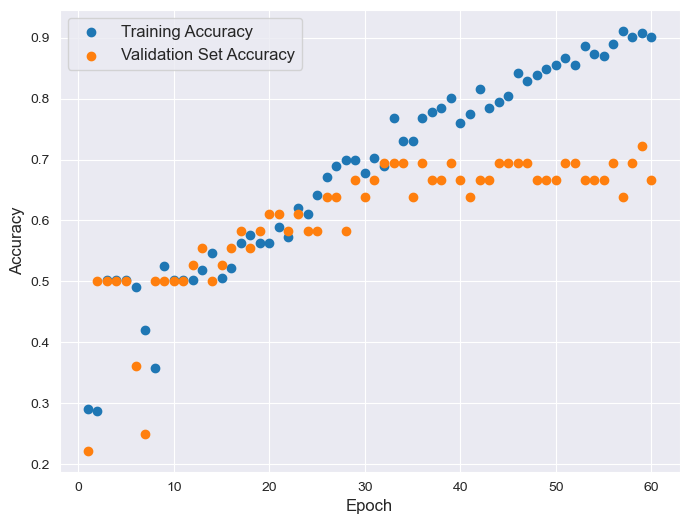

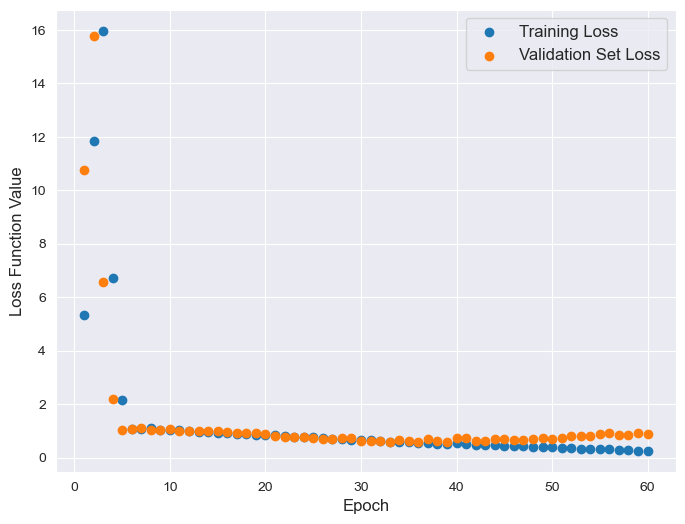

In [299]:
plottv(history.history_,epochs)

316